In [87]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os

from scipy import stats
from IPython.display import display, HTML
import glob
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.utils import np_utils

In [58]:
from sklearn.utils import shuffle

In [34]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = list('ABCDEFGHIJKLMNOPQRS')

# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

keras version  2.2.4


In [35]:
column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']


In [36]:
def get_data(read_files):
    
    df = pd.DataFrame(columns=column_names) #decalaring a pandas dataframe
    for file_path in read_files:
        new_df = pd.read_csv(file_path,
                         header=None,
                         names=column_names)

        df = df.append(new_df,ignore_index=True,sort=False)

    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)

    df.dropna(axis=0, how='any', inplace=True)
    
    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan

In [37]:
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [38]:
folder_path = '/home/dhruv/Desktop/fun/HAR/raw/train/phone/accel/'
read_files = glob.glob(os.path.join(folder_path,"*.txt"))
print(len(read_files))
df_train = get_data(read_files)

20


In [40]:
files_path = '/home/dhruv/Desktop/fun/HAR/raw/test/phone/accel/'
read_files = glob.glob(os.path.join(files_path,"*.txt"))
print(len(read_files))
df_test = get_data(read_files)

14


In [42]:
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [45]:
pd.options.mode.chained_assignment = None  # default='warn'
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()
# Round numbers
df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [46]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df_train[LABEL] = le.fit_transform(df_train['activity'].values.ravel())
df_test[LABEL] =le.fit_transform(df_test['activity'].values.ravel()) 

In [63]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [69]:
x_train, y_train = shuffle(x_train, y_train, random_state=0)

In [74]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (39505, 80, 3)
39505 training samples
y_train shape:  (39505,)


In [75]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'O', 'P', 'Q', 'R', 'S']


In [76]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (39505, 240)
input_shape: 240


In [77]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [78]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (39505, 18)


In [88]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 160)           160160    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 160)            256160    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 160)               0         
__________

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 31604 samples, validate on 7901 samples
Epoch 1/50
31604/31604 [==============================] - 77s 2ms/step - loss: 2.2243 - acc: 0.2237 - val_loss: 1.9207 - val_acc: 0.3027
Epoch 2/50
31604/31604 [==============================] - 85s 3ms/step - loss: 1.8726 - acc: 0.3257 - val_loss: 1.6974 - val_acc: 0.3921
Epoch 3/50
31604/31604 [==============================] - 87s 3ms/step - loss: 1.7557 - acc: 0.3693 - val_loss: 1.4909 - val_acc: 0.4720
Epoch 4/50
31604/31604 [==============================] - 86s 3ms/step - loss: 1.5744 - acc: 0.4308 - val_loss: 1.8199 - val_acc: 0.3887
Epoch 5/50
31604/31604 [==============================] - 90s 3ms/step - loss: 1.5127 - acc: 0.4522 - val_loss: 1.2765 - val_acc: 0.5485
Epoch 6/50
31604/31604 [==============================] - 91s 3ms/step - loss: 1.3659 - acc: 0.5050 - val_loss: 1.1815 - val_acc: 0.5841
Epoch 7/50
31604/31604 [==============================] - 93s 3ms/step - loss: 1.2976 - acc: 0.5281 - val_loss: 1.1271 - val_acc:

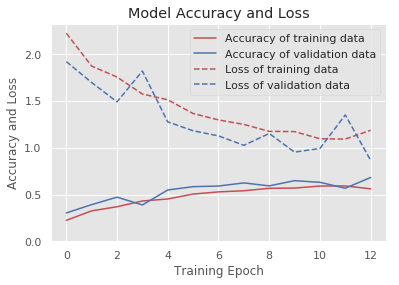

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94      2317
         1.0       0.99      0.98      0.99      2033
         2.0       0.88      0.82      0.85      2200
         3.0       0.66      0.64      0.65      2071
         4.0       0.79      0.86      0.82      2067
         5.0       0.61      0.68      0.64      1977
         6.0       0.60      0.73      0.66      2066
         7.0       0.52      0.61      0.56      2335
         8.0       0.66      0.51      0.58      2180
         9.0       0.67      0.51      0.58      2087
        10.0       0.62      0.57      0.60      2322
        11.0       0.36      0.60      0.45      2282
        12.0       0.77      0.65      0.70      2486
        13.0       0.64      0.71      0.67      2386
        14.0       0.74      0.81      0.77      2472
        15.0       0.79      0.66      0.72      2072
        16.0       0.78      0.42      0.55      2064
        17.0       0.71    

In [90]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train)) #get prec,recall and f1

In [91]:
x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

32099/32099 [==============================] - 30s 930us/step

Accuracy on test data: 0.18

Loss on test data: 9.35
